# The Model

Let me remind us the model architecture

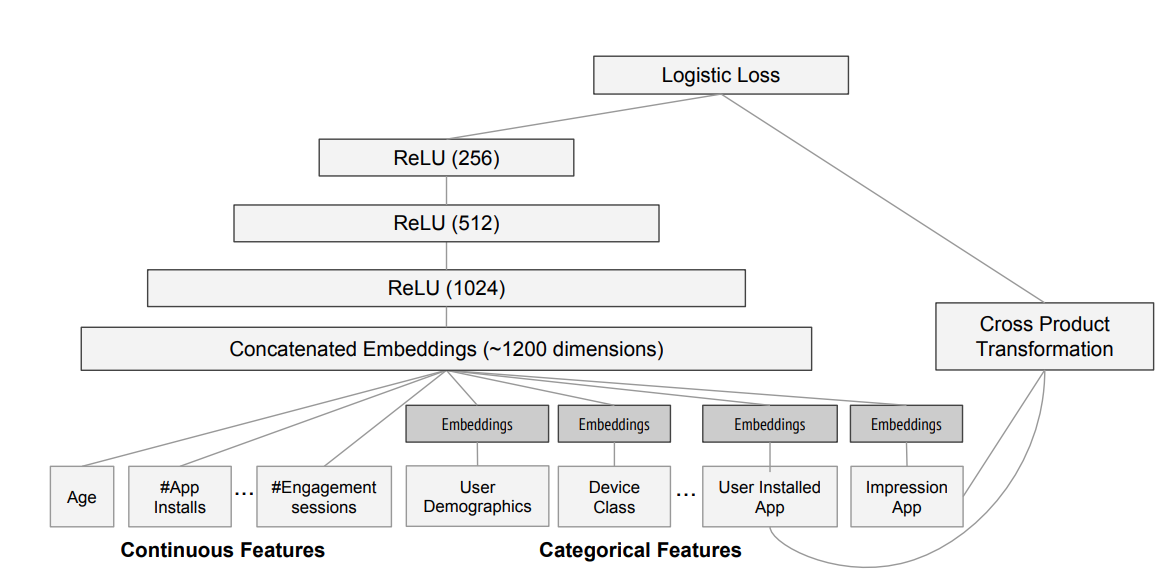

In [59]:
from IPython.display import Image
Image(filename = "figures/model_fig2.png", width=600, height=300)

Expression 3 in the paper is:

$$
P(Y = 1|x) = \sigma(W^{T}_{wide}[x, \phi(x)] + W^{T}_{deep}a^{(l_f)} + b)
$$

Where $Y$ is the binary class label (in their case they perform a logistic regression),  $\sigma(\cdot)$ is the activation function, in their case Sigmoid, $\phi(x)$ are the cross product transformations of the original features $x$, and $b$ is the bias term. $W_{wide}$ is the vector of all wide model weights, and $W_{deep}$ are the weights applied on the final activations $a^{(l_f)}$. 

## 1. Wide

The wide part consist simply in the sparse features connected directly to the output neuron (or neurons if the problem is a multiclass classification). Assuming that we perform a logistic regression or a regression, we need to connect the input features to an output neuron and use a *Sigmoid* activation function if logistic regression or no activation at all if regression. 

In [56]:
import numpy as np
import torch
import torch.nn as nn

class Wide(nn.Module):
    def __init__(self, wide_dim, output_dim):
        super(Wide, self).__init__()
        self.wlinear = nn.Linear(wide_dim, output_dim)

    def forward(self, X):
        out = self.wlinear(X)
        return out

In [8]:
toy_wide = Wide(100, 1)
toy_wide

Wide(
  (wlinear): Linear(in_features=100, out_features=1, bias=True)
)

Let's load the data bunch we save after demo 1.

In [10]:
import pickle

wd_data = pickle.load(open("data/wide_deep_data.p", "rb"))
print(list(wd_adult.keys()))

['wide', 'deep', 'embed_input', 'encoding_dict', 'deep_column_idx', 'cont_cols']


As expected, a sparse matrix of the one hot encoded categorical features. Let's just run the Wide model

In [15]:
wide = Wide(wide_dim=wd_data.wide.shape[1], output_dim=1)
out = wide(torch.tensor(wd_data.wide[:10]).float())
out

tensor([[ 0.0982],
        [ 0.0080],
        [ 0.0630],
        [-0.0212],
        [ 0.0260],
        [-0.0856],
        [ 0.0013],
        [-0.0114],
        [-0.0407],
        [-0.0494]], grad_fn=<AddmmBackward>)

## 2. Deep-Dense

Here the model is a little more complex, let's have a look

In [54]:
def dense_layer(inp, out, p, bn=False):
    layers = [nn.Linear(inp, out), nn.LeakyReLU(inplace=True)]
    if bn:
        layers.append(nn.BatchNorm1d(out))
    layers.append(nn.Dropout(p))
    return nn.Sequential(*layers)


class Deep(nn.Module):
    def __init__(self, hidden_layers, embed_input, continuous_cols, deep_column_idx, batchnorm = False, 
                 dropout = None, embed_p = 0.0, output_dim=1):

        super(Deep, self).__init__()
        self.embed_input = embed_input
        self.continuous_cols = continuous_cols
        self.deep_column_idx = deep_column_idx

        # Embeddings
        self.embed_layers = nn.ModuleDict(
            {
                "emb_layer_" + col: nn.Embedding(val, dim)
                for col, val, dim in self.embed_input
            }
        )
        self.embed_dropout = nn.Dropout(embed_p)
        emb_inp_dim = np.sum([embed[2] for embed in self.embed_input])

        # Continuous
        cont_inp_dim = len(self.continuous_cols)

        # Dense Layers
        input_dim = emb_inp_dim + cont_inp_dim
        hidden_layers = [input_dim] + hidden_layers
        if not dropout:
            dropout = [0.0] * len(hidden_layers)
        self.dense = nn.Sequential()
        for i in range(1, len(hidden_layers)):
            self.dense.add_module(
                "dense_layer_{}".format(i - 1),
                dense_layer(
                    hidden_layers[i - 1], hidden_layers[i], dropout[i - 1], batchnorm
                ),
            )

        self.out = nn.Linear(hidden_layers[-1], output_dim)
        
    def forward(self, X):

        # Embeddings
        x = [
            self.embed_layers["emb_layer_" + col](
                X[:, self.deep_column_idx[col]].long()
            )
            for col, _, _ in self.embed_input
        ]
        x = torch.cat(x, 1)  
        x = self.embed_dropout(x)

        # Continuous 
        cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
        x_cont = X[:, cont_idx].float()
        x = torch.cat([x, x_cont], 1)
        
        # Dense
        return self.out(self.dense(x))

### 3.1 Categorical Embeddings

In [23]:
wd_data.embed_input

[('workclass', 9, 10),
 ('education', 16, 10),
 ('occupation', 15, 10),
 ('relationship', 6, 10),
 ('native_country', 42, 16)]

In [25]:
wd_data.deep_column_idx

{'workclass': 0,
 'education': 1,
 'occupation': 2,
 'relationship': 3,
 'native_country': 4,
 'age': 5,
 'hours_per_week': 6}

In [26]:
wd_data.deep

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.02599598, -0.03408696],
       [ 1.        ,  0.        ,  1.        , ...,  0.        ,
         0.82830842, -2.21303208],
       [ 2.        ,  1.        ,  2.        , ...,  0.        ,
        -0.04694151, -0.03408696],
       ...,
       [ 2.        ,  0.        ,  3.        , ...,  0.        ,
        -0.04694151,  0.77292975],
       [ 2.        ,  0.        ,  0.        , ...,  0.        ,
         0.39068346, -0.03408696],
       [ 6.        ,  0.        ,  1.        , ...,  0.        ,
        -0.26575399,  1.57994645]])

In [27]:
embed_layers = nn.ModuleDict(
            {
                "emb_layer_" + col: nn.Embedding(val, dim)
                for col, val, dim in wd_data.embed_input
            }
          )

In [28]:
embed_layers

ModuleDict(
  (emb_layer_education): Embedding(16, 10)
  (emb_layer_native_country): Embedding(42, 16)
  (emb_layer_occupation): Embedding(15, 10)
  (emb_layer_relationship): Embedding(6, 10)
  (emb_layer_workclass): Embedding(9, 10)
)

In [47]:
X = torch.tensor(wd_data.deep[:10])
x = [
    embed_layers["emb_layer_" + col](
        X[:, wd_data.deep_column_idx[col]].long()
    )
    for col, _, _ in wd_data.embed_input
]

In [48]:
print(len(x))
print(x[0].shape)
print(torch.cat(x, 1).shape)

5
torch.Size([10, 10])
torch.Size([10, 56])


In [49]:
x = torch.cat(x, 1)

### 3.2 Continuous  

In [51]:
continuous_cols = ['age','hours_per_week']
cont_idx = [wd_data.deep_column_idx[col] for col in continuous_cols]
x_cont = X[:, cont_idx].float()
x = torch.cat([x, x_cont], 1)

In [53]:
x.shape

torch.Size([10, 58])

In [57]:
toy_deep = Deep(
    hidden_layers = [64,32], 
    embed_input = wd_data.embed_input, 
    continuous_cols = wd_data.cont_cols,
    deep_column_idx = wd_data.deep_column_idx)

In [58]:
toy_deep

Deep(
  (embed_layers): ModuleDict(
    (emb_layer_education): Embedding(16, 10)
    (emb_layer_native_country): Embedding(42, 16)
    (emb_layer_occupation): Embedding(15, 10)
    (emb_layer_relationship): Embedding(6, 10)
    (emb_layer_workclass): Embedding(9, 10)
  )
  (embed_dropout): Dropout(p=0.0, inplace=False)
  (dense): Sequential(
    (dense_layer_0): Sequential(
      (0): Linear(in_features=58, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (dense_layer_1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
    )
  )
)